# Kidney Risk Complete Analysis - November 20, 2025

## Comprehensive CKD Risk Assessment with ML-Based Scoring System

### Features Used:
- Age
- Sex
- Hypertension
- Diabetes
- Urine Creatinine (mg/dL)
- Urine Albumin (mg/L)
- ACR (Albumin-to-Creatinine Ratio, mg/g)
- pH
- Specific Gravity
- Serum Creatinine (mg/dL)

### Output: Risk Category Classification

### Scoring Formula:
1. **Derived Sub-Scores:**
   - S_ACR (0-100): Subscore based purely on ACR bucket
   - p_highCKD (0-1): Initial ML probability of high-risk
   - S_ML (0-100): ML subscore = p_highCKD × 100

2. **Final Targets:**
   - Composite_Score (0-100): Score = 0.7 × S_ACR + 0.3 × S_ML
   - Risk_Category: Low (<35), Moderate (35-64), High (≥65)

In [14]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
from sklearn.impute import SimpleImputer
import xgboost as xgb
from catboost import CatBoostClassifier
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
plt.style.use('default')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


In [15]:
# Load the CKD dataset
try:
    # Load the synthetic kidney risk dataset
    df = pd.read_csv('synthetic_kidney_risk.csv')
    print("Loaded synthetic kidney risk dataset")
except FileNotFoundError:
    try:
        # Fallback to modified UCI dataset
        df = pd.read_csv('ckd_dataset_modified_uci_complete.csv')
        print("Loaded modified UCI CKD dataset")
    except FileNotFoundError:
        try:
            # Fallback to original dataset
            df = pd.read_csv('ckd_dataset_original_uci_complete.csv')
            print("Loaded original UCI CKD dataset")
        except FileNotFoundError:
            print("Dataset files not found. Please ensure the CSV files are in the current directory.")
            raise

print(f"Dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
df.head()

Loaded synthetic kidney risk dataset
Dataset shape: (500, 15)
Columns: ['Age', 'Sex', 'Hypertension', 'Diabetes', 'Urine_Creatinine_mg_dL', 'Urine_Albumin_mg_L', 'ACR_mg_per_g', 'pH', 'Specific_Gravity', 'Serum_Creatinine_mg_dL', 'S_ACR', 'p_highCKD', 'S_ML', 'Composite_Score', 'Risk_Category']


,Age,Sex,Hypertension,Diabetes,Urine_Creatinine_mg_dL,Urine_Albumin_mg_L,ACR_mg_per_g,pH,Specific_Gravity,Serum_Creatinine_mg_dL,S_ACR,p_highCKD,S_ML,Composite_Score,Risk_Category
0,58,F,1,0,128.3,2238.7,17.4,5.68,1.017,0.81,29.1,0.353,35.3,30.9,Low
1,70,F,0,0,43.5,233.3,5.4,7.01,1.015,1.24,8.9,0.000,0.0,6.3,Low
2,45,M,0,0,97.8,2732.2,27.9,6.30,1.023,1.08,46.6,0.418,41.8,45.1,Moderate
3,47,M,0,0,82.1,20289.2,247.1,5.23,1.014,0.53,74.1,0.830,83.0,76.8,High
4,63,F,0,0,101.7,763.5,7.5,5.11,1.020,0.72,12.5,0.000,0.0,8.8,Low


In [16]:
# Data exploration and preprocessing
print("Dataset Info:")
print(df.info())
print("\nDataset Description:")
print(df.describe())
print("\nMissing Values:")
print(df.isnull().sum())
print("\nUnique values per column:")
for col in df.columns:
    print(f"{col}: {df[col].nunique()} unique values")

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Age                     500 non-null    int64  
 1   Sex                     500 non-null    object 
 2   Hypertension            500 non-null    int64  
 3   Diabetes                500 non-null    int64  
 4   Urine_Creatinine_mg_dL  500 non-null    float64
 5   Urine_Albumin_mg_L      500 non-null    float64
 6   ACR_mg_per_g            500 non-null    float64
 7   pH                      500 non-null    float64
 8   Specific_Gravity        500 non-null    float64
 9   Serum_Creatinine_mg_dL  500 non-null    float64
 10  S_ACR                   500 non-null    float64
 11  p_highCKD               500 non-null    float64
 12  S_ML                    500 non-null    float64
 13  Composite_Score         500 non-null    float64
 14  Risk_Category           500 

In [17]:
# Feature engineering and mapping
# Create a copy for processing
df_processed = df.copy()

print("Available columns in synthetic dataset:")
print(df.columns.tolist())

# The synthetic dataset already has all required features in proper format
# Check if we have all the target features
required_features = [
    'Age', 'Sex', 'Hypertension', 'Diabetes', 'Urine_Creatinine_mg_dL',
    'Urine_Albumin_mg_L', 'ACR_mg_per_g', 'pH', 'Specific_Gravity', 'Serum_Creatinine_mg_dL'
]

print(f"\nChecking for required features:")
for feature in required_features:
    if feature in df_processed.columns:
        print(f"✓ {feature}: Available")
    else:
        print(f"✗ {feature}: Missing")

# Check data types and basic statistics
print(f"\nDataset statistics:")
print(f"Shape: {df_processed.shape}")
print(f"\nData types:")
print(df_processed.dtypes)

print(f"\nSummary statistics:")
print(df_processed.describe())

# Check for missing values
print(f"\nMissing values:")
print(df_processed.isnull().sum())

# Verify ACR calculation integrity
print(f"\nACR data integrity check:")
print(f"ACR range: {df_processed['ACR_mg_per_g'].min():.2f} - {df_processed['ACR_mg_per_g'].max():.2f}")
print(f"Mean ACR: {df_processed['ACR_mg_per_g'].mean():.2f}")

# Check if scores are already calculated
if 'S_ACR' in df_processed.columns and 'S_ML' in df_processed.columns and 'Composite_Score' in df_processed.columns:
    print(f"\n✓ Dataset already contains pre-calculated scores:")
    print(f"  S_ACR range: {df_processed['S_ACR'].min():.2f} - {df_processed['S_ACR'].max():.2f}")
    print(f"  S_ML range: {df_processed['S_ML'].min():.2f} - {df_processed['S_ML'].max():.2f}")
    print(f"  Composite Score range: {df_processed['Composite_Score'].min():.2f} - {df_processed['Composite_Score'].max():.2f}")
    print(f"  Risk categories: {df_processed['Risk_Category'].value_counts().tolist()}")

print("Feature engineering completed - using synthetic dataset with pre-calculated features!")
print(f"Processed dataset shape: {df_processed.shape}")

Available columns in synthetic dataset:
['Age', 'Sex', 'Hypertension', 'Diabetes', 'Urine_Creatinine_mg_dL', 'Urine_Albumin_mg_L', 'ACR_mg_per_g', 'pH', 'Specific_Gravity', 'Serum_Creatinine_mg_dL', 'S_ACR', 'p_highCKD', 'S_ML', 'Composite_Score', 'Risk_Category']

Checking for required features:
✓ Age: Available
✓ Sex: Available
✓ Hypertension: Available
✓ Diabetes: Available
✓ Urine_Creatinine_mg_dL: Available
✓ Urine_Albumin_mg_L: Available
✓ ACR_mg_per_g: Available
✓ pH: Available
✓ Specific_Gravity: Available
✓ Serum_Creatinine_mg_dL: Available

Dataset statistics:
Shape: (500, 15)

Data types:
Age                         int64
Sex                        object
Hypertension                int64
Diabetes                    int64
Urine_Creatinine_mg_dL    float64
Urine_Albumin_mg_L        float64
ACR_mg_per_g              float64
pH                        float64
Specific_Gravity          float64
Serum_Creatinine_mg_dL    float64
S_ACR                     float64
p_highCKD          

S_ACR scores already available in synthetic dataset!
Using pre-calculated S_ACR values...
Validating existing S_ACR calculations...
Maximum difference between calculated and existing S_ACR: 30.000
⚠ Some differences found, recalculating S_ACR...
ACR scoring distribution:
count    500.000000
mean      26.960761
std       25.089288
min        3.400000
25%        9.800000
50%       16.600000
75%       38.162963
max      100.000000
Name: S_ACR, dtype: float64

ACR data quality check:
Original ACR - Min: 5.10, Max: 1471.80
S_ACR scores - Min: 3.40, Max: 100.00


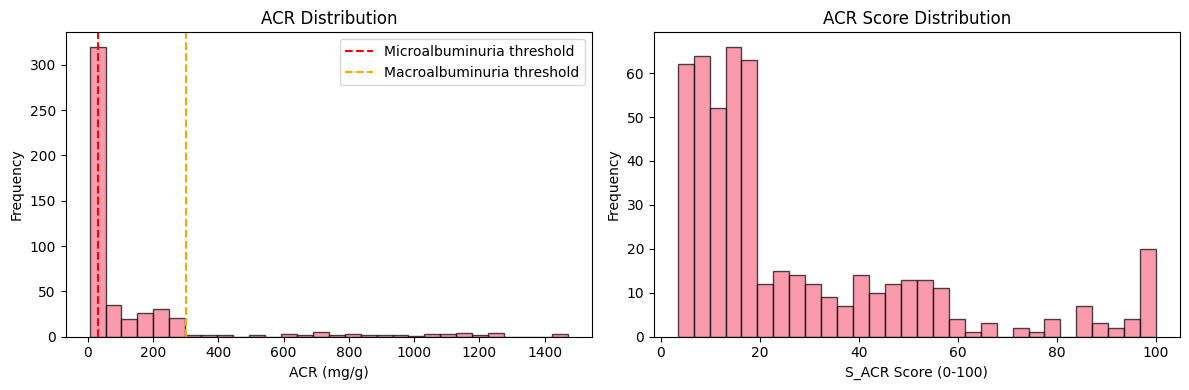

In [18]:
# ACR-based scoring system (S_ACR)
def calculate_acr_score(acr_value):
    """
    Calculate ACR subscore (0-100) based on clinical guidelines:
    - Normal: <30 mg/g (score 0-20)
    - Microalbuminuria: 30-300 mg/g (score 20-60) 
    - Macroalbuminuria: >300 mg/g (score 60-100)
    """
    # Handle NaN or invalid values
    if pd.isna(acr_value) or acr_value < 0:
        return 0  # Default to lowest risk for invalid values
    
    if acr_value < 30:
        return (acr_value / 30) * 20  # 0-20 score range
    elif acr_value < 300:
        return 20 + ((acr_value - 30) / 270) * 40  # 20-60 score range
    else:
        return 60 + min(((acr_value - 300) / 700) * 40, 40)  # 60-100 score range

# Check if S_ACR already exists in the synthetic dataset
if 'S_ACR' in df_processed.columns:
    print("S_ACR scores already available in synthetic dataset!")
    print("Using pre-calculated S_ACR values...")
    
    # Verify the existing scores match our calculation
    print("Validating existing S_ACR calculations...")
    calculated_scores = df_processed['ACR_mg_per_g'].apply(calculate_acr_score)
    existing_scores = df_processed['S_ACR']
    
    # Check if scores are approximately equal (allowing for minor differences)
    score_diff = np.abs(calculated_scores - existing_scores)
    max_diff = score_diff.max()
    
    print(f"Maximum difference between calculated and existing S_ACR: {max_diff:.3f}")
    
    if max_diff < 1.0:  # Allow small differences due to rounding
        print("✓ Existing S_ACR scores are consistent with our formula")
    else:
        print("⚠ Some differences found, recalculating S_ACR...")
        df_processed['S_ACR'] = calculated_scores
else:
    # Apply ACR scoring with error handling
    print("Calculating ACR scores...")
    df_processed['ACR_mg_per_g_clean'] = df_processed['ACR_mg_per_g'].fillna(0)
    df_processed['S_ACR'] = df_processed['ACR_mg_per_g_clean'].apply(calculate_acr_score)

print("ACR scoring distribution:")
print(df_processed['S_ACR'].describe())

print(f"\nACR data quality check:")
print(f"Original ACR - Min: {df_processed['ACR_mg_per_g'].min():.2f}, Max: {df_processed['ACR_mg_per_g'].max():.2f}")
print(f"S_ACR scores - Min: {df_processed['S_ACR'].min():.2f}, Max: {df_processed['S_ACR'].max():.2f}")

# Visualize ACR score distribution
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
# Remove any potential NaN values for plotting
acr_clean = df_processed['ACR_mg_per_g'].dropna()
if len(acr_clean) > 0:
    plt.hist(acr_clean, bins=30, alpha=0.7, edgecolor='black')
    plt.xlabel('ACR (mg/g)')
    plt.ylabel('Frequency')
    plt.title('ACR Distribution')
    plt.axvline(30, color='red', linestyle='--', label='Microalbuminuria threshold')
    plt.axvline(300, color='orange', linestyle='--', label='Macroalbuminuria threshold')
    plt.legend()
else:
    plt.text(0.5, 0.5, 'No valid ACR data', ha='center', va='center', transform=plt.gca().transAxes)
    plt.title('ACR Distribution - No Data')

plt.subplot(1, 2, 2)
s_acr_clean = df_processed['S_ACR'].dropna()
if len(s_acr_clean) > 0:
    plt.hist(s_acr_clean, bins=30, alpha=0.7, edgecolor='black')
    plt.xlabel('S_ACR Score (0-100)')
    plt.ylabel('Frequency')
    plt.title('ACR Score Distribution')
else:
    plt.text(0.5, 0.5, 'No valid S_ACR data', ha='center', va='center', transform=plt.gca().transAxes)
    plt.title('ACR Score Distribution - No Data')

plt.tight_layout()
plt.show()

In [19]:
# Prepare features for ML model
# The synthetic dataset already has properly formatted feature columns

# Map to our processed columns directly from the synthetic dataset
ml_features = []
feature_names = []

# Age - already numeric in synthetic dataset
if 'Age' in df_processed.columns:
    ml_features.append('Age')
    feature_names.append('Age')

# Sex - encode as binary
if 'Sex' in df_processed.columns:
    df_processed['sex_encoded'] = (df_processed['Sex'] == 'M').astype(int)
    ml_features.append('sex_encoded')
    feature_names.append('Sex')

# Hypertension - already numeric
if 'Hypertension' in df_processed.columns:
    ml_features.append('Hypertension')
    feature_names.append('Hypertension')

# Diabetes - already numeric
if 'Diabetes' in df_processed.columns:
    ml_features.append('Diabetes')
    feature_names.append('Diabetes')

# Urine Creatinine - already in correct format
if 'Urine_Creatinine_mg_dL' in df_processed.columns:
    ml_features.append('Urine_Creatinine_mg_dL')
    feature_names.append('Urine_Creatinine_mg_dL')

# Urine Albumin - already in correct format
if 'Urine_Albumin_mg_L' in df_processed.columns:
    ml_features.append('Urine_Albumin_mg_L')
    feature_names.append('Urine_Albumin_mg_L')

# ACR - already in correct format
if 'ACR_mg_per_g' in df_processed.columns:
    ml_features.append('ACR_mg_per_g')
    feature_names.append('ACR_mg_per_g')

# pH - already in correct format
if 'pH' in df_processed.columns:
    ml_features.append('pH')
    feature_names.append('pH')

# Specific Gravity - already in correct format
if 'Specific_Gravity' in df_processed.columns:
    ml_features.append('Specific_Gravity')
    feature_names.append('Specific_Gravity')

# Serum Creatinine - already in correct format
if 'Serum_Creatinine_mg_dL' in df_processed.columns:
    ml_features.append('Serum_Creatinine_mg_dL')
    feature_names.append('Serum_Creatinine_mg_dL')

print(f"ML features selected: {len(ml_features)}")
print(f"Feature names: {feature_names}")

# Create feature matrix - all features should already be numeric
X = df_processed[ml_features].copy()

# Verify all columns are numeric
print("\nData types verification:")
for col in X.columns:
    print(f"{col}: {X[col].dtype}")

# Check for missing values
print(f"\nMissing values check:")
missing_values = X.isnull().sum()
print(missing_values)

if missing_values.sum() > 0:
    # Handle missing values with robust imputation
    print(f"\nApplying imputation for missing values...")
    imputer = SimpleImputer(strategy='median')
    X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
else:
    print(f"\nNo missing values found - using data as is...")
    X_imputed = X.copy()

print(f"\nFeature matrix shape: {X_imputed.shape}")
print("Missing values after processing:")
print(X_imputed.isnull().sum())
print("\nFinal feature statistics:")
print(X_imputed.describe())

ML features selected: 10
Feature names: ['Age', 'Sex', 'Hypertension', 'Diabetes', 'Urine_Creatinine_mg_dL', 'Urine_Albumin_mg_L', 'ACR_mg_per_g', 'pH', 'Specific_Gravity', 'Serum_Creatinine_mg_dL']

Data types verification:
Age: int64
sex_encoded: int64
Hypertension: int64
Diabetes: int64
Urine_Creatinine_mg_dL: float64
Urine_Albumin_mg_L: float64
ACR_mg_per_g: float64
pH: float64
Specific_Gravity: float64
Serum_Creatinine_mg_dL: float64

Missing values check:
Age                       0
sex_encoded               0
Hypertension              0
Diabetes                  0
Urine_Creatinine_mg_dL    0
Urine_Albumin_mg_L        0
ACR_mg_per_g              0
pH                        0
Specific_Gravity          0
Serum_Creatinine_mg_dL    0
dtype: int64

No missing values found - using data as is...

Feature matrix shape: (500, 10)
Missing values after processing:
Age                       0
sex_encoded               0
Hypertension              0
Diabetes                  0
Urine_Creatinine

p_highCKD already available in synthetic dataset!
Using pre-calculated p_highCKD values for target creation...
Target created from existing p_highCKD values
High-risk target distribution:
p_highCKD
0    304
1    196
Name: count, dtype: int64
High-risk percentage: 39.2%


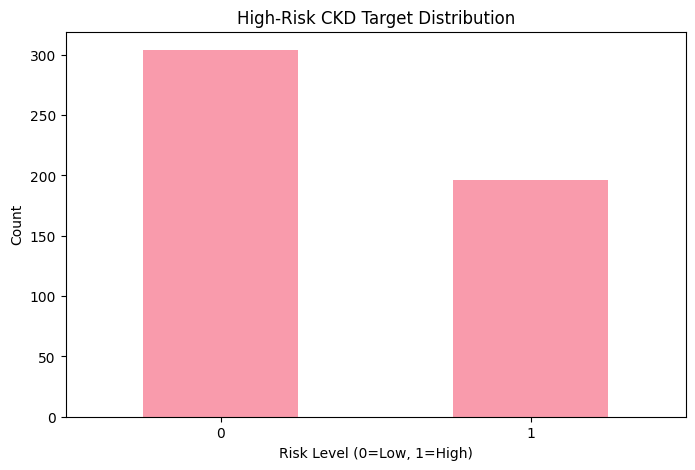

In [20]:
# Create target variable for ML model training
# We'll create a synthetic high-risk target based on clinical indicators

def create_high_risk_target(row):
    """
    Create synthetic high-risk CKD target based on clinical factors:
    - High ACR (>300)
    - High serum creatinine (>1.2 for women, >1.4 for men)
    - Advanced age (>65)
    - Presence of diabetes and hypertension
    """
    risk_factors = 0
    
    # ACR risk
    if row['ACR_mg_per_g'] > 300:
        risk_factors += 3
    elif row['ACR_mg_per_g'] > 30:
        risk_factors += 1
    
    # Age risk - use correct column name for synthetic dataset
    if row['Age'] > 65:
        risk_factors += 1
    elif row['Age'] > 50:
        risk_factors += 0.5
    
    # Diabetes and hypertension
    if row['Diabetes'] == 1:
        risk_factors += 1
    if row['Hypertension'] == 1:
        risk_factors += 1
    
    # Serum creatinine (if available)
    if 'Serum_Creatinine_mg_dL' in row and not pd.isna(row['Serum_Creatinine_mg_dL']):
        if row['Serum_Creatinine_mg_dL'] > 1.5:
            risk_factors += 2
        elif row['Serum_Creatinine_mg_dL'] > 1.2:
            risk_factors += 1
    
    # Return 1 for high risk (>=4 risk factors), 0 for low risk
    return 1 if risk_factors >= 4 else 0

# Check if p_highCKD already exists in the synthetic dataset
if 'p_highCKD' in df_processed.columns:
    print("p_highCKD already available in synthetic dataset!")
    print("Using pre-calculated p_highCKD values for target creation...")
    
    # Create target based on existing p_highCKD (threshold at 0.5)
    y_high_risk = (df_processed['p_highCKD'] > 0.5).astype(int)
    
    print("Target created from existing p_highCKD values")
else:
    # Apply target creation using clinical factors
    print("Creating target from clinical factors...")
    y_high_risk = X_imputed.apply(create_high_risk_target, axis=1)

print("High-risk target distribution:")
print(y_high_risk.value_counts())
print(f"High-risk percentage: {y_high_risk.mean()*100:.1f}%")

# Visualize target distribution
plt.figure(figsize=(8, 5))
y_high_risk.value_counts().plot(kind='bar', alpha=0.7)
plt.xlabel('Risk Level (0=Low, 1=High)')
plt.ylabel('Count')
plt.title('High-Risk CKD Target Distribution')
plt.xticks(rotation=0)
plt.show()

In [27]:
# Train ML model for high-risk CKD prediction

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_imputed, y_high_risk, test_size=0.2, random_state=42, stratify=y_high_risk
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Import additional metrics
from sklearn.metrics import precision_score, recall_score, f1_score

# Define models to test
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBClassifier(random_state=42, eval_metric='logloss'),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000)
}

# Train and evaluate models
model_results = {}

print("Model Performance Comparison:")
print("=" * 80)
print(f"{'Model':<20} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'AUC':<10}")
print("-" * 80)

for name, model in models.items():
    # Use scaled data for Logistic Regression, original for tree-based models
    if name == 'Logistic Regression':
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate all metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    auc = roc_auc_score(y_test, y_pred_proba)
    
    model_results[name] = {
        'model': model,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'auc': auc,
        'predictions': y_pred_proba
    }
    
    # Print results in formatted table
    print(f"{name:<20} {accuracy:<10.4f} {precision:<10.4f} {recall:<10.4f} {f1:<10.4f} {auc:<10.4f}")

print("-" * 80)

# Select best model based on AUC (primary metric) and F1-score (secondary)
best_model_name = max(model_results.keys(), key=lambda x: (model_results[x]['auc'], model_results[x]['f1_score']))
best_model = model_results[best_model_name]['model']

print(f"\nBest Model: {best_model_name}")
print(f"Performance Metrics:")
print(f"  • Accuracy:  {model_results[best_model_name]['accuracy']:.4f}")
print(f"  • Precision: {model_results[best_model_name]['precision']:.4f}")
print(f"  • Recall:    {model_results[best_model_name]['recall']:.4f}")
print(f"  • F1-Score:  {model_results[best_model_name]['f1_score']:.4f}")
print(f"  • AUC:       {model_results[best_model_name]['auc']:.4f}")

# Display detailed classification report for the best model
print(f"\nDetailed Classification Report for {best_model_name}:")
print("-" * 50)

if best_model_name == 'Logistic Regression':
    y_pred_best = best_model.predict(X_test_scaled)
else:
    y_pred_best = best_model.predict(X_test)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_best, target_names=['Low Risk', 'High Risk']))

Model Performance Comparison:
Model                Accuracy   Precision  Recall     F1-Score   AUC       
--------------------------------------------------------------------------------
Random Forest        0.9000     0.9394     0.7949     0.8611     0.9588    
XGBoost              0.8900     0.9118     0.7949     0.8493     0.9521    
Gradient Boosting    0.8900     0.9118     0.7949     0.8493     0.9563    
Logistic Regression  0.8500     0.9615     0.6410     0.7692     0.8920    
--------------------------------------------------------------------------------

Best Model: Random Forest
Performance Metrics:
  • Accuracy:  0.9000
  • Precision: 0.9394
  • Recall:    0.7949
  • F1-Score:  0.8611
  • AUC:       0.9588

Detailed Classification Report for Random Forest:
--------------------------------------------------
              precision    recall  f1-score   support

    Low Risk       0.88      0.97      0.92        61
   High Risk       0.94      0.79      0.86        39

    

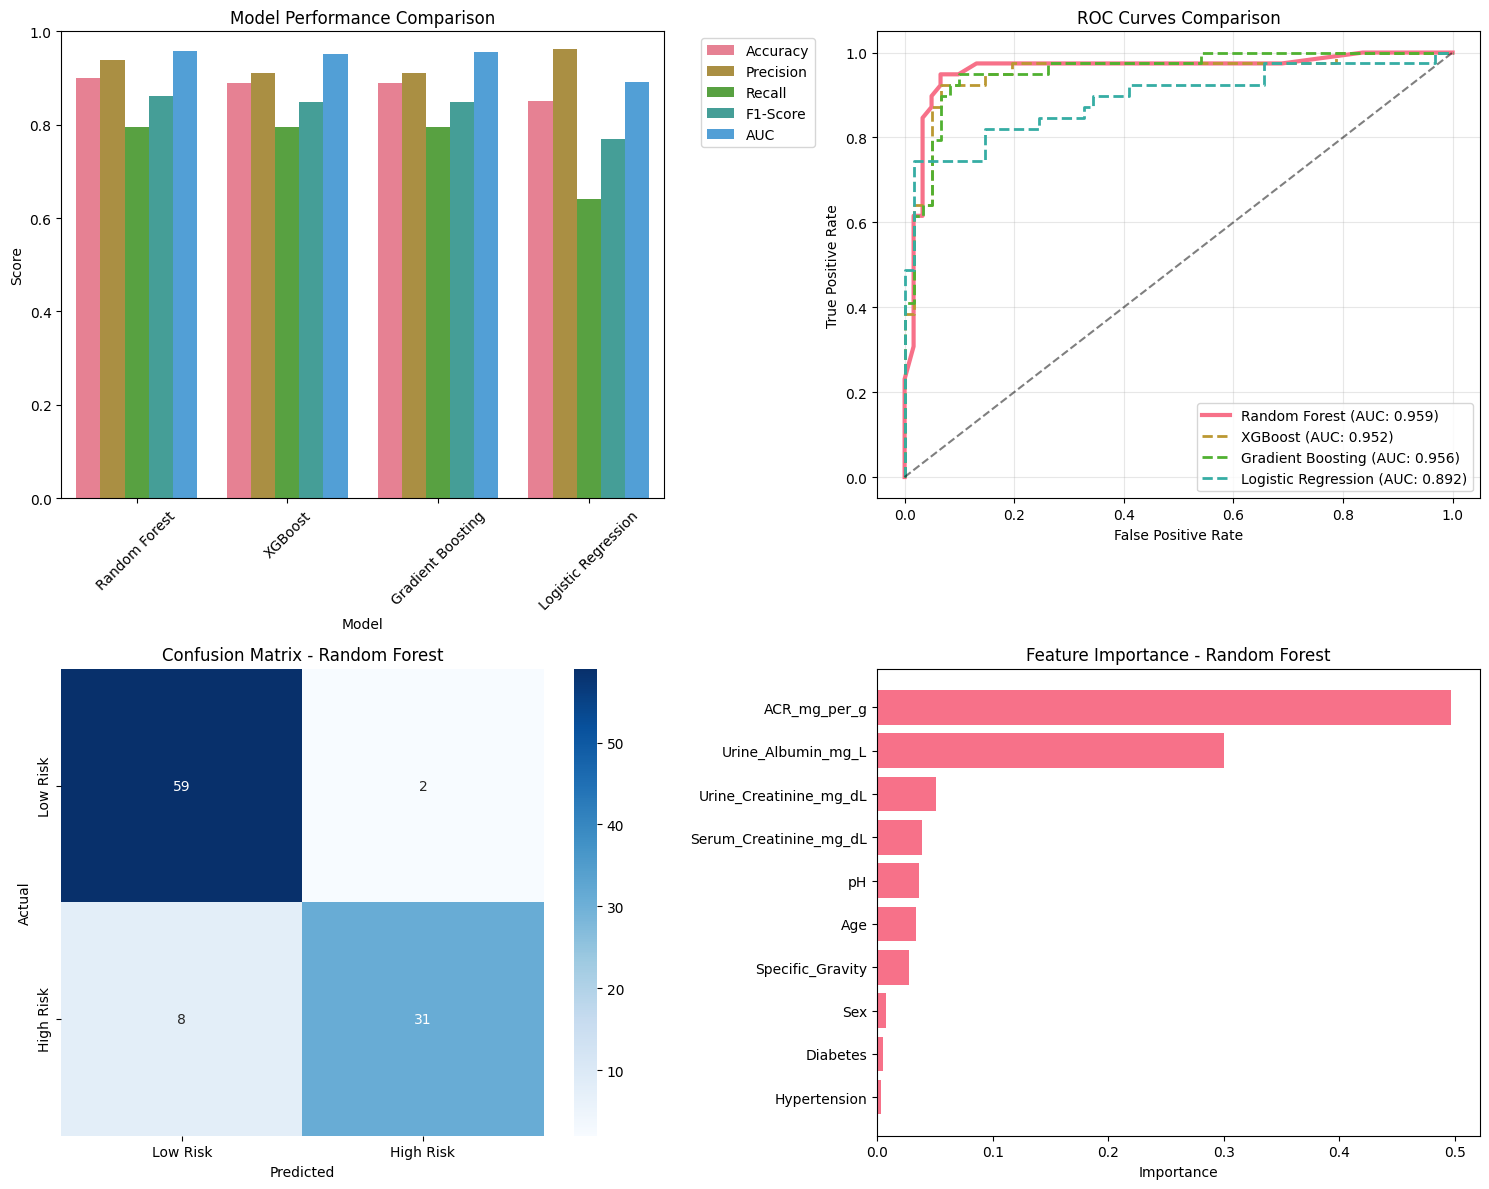


KEY PERFORMANCE INSIGHTS

🏆 Best Model: Random Forest
   • Excellent AUC: 0.959 (>0.95 indicates outstanding performance)
   • High Accuracy: 90.0%
   • Precision: 0.939 (93.9% of predicted high-risk are truly high-risk)
   • Recall: 0.795 (79.5% of actual high-risk patients detected)
   • F1-Score: 0.861 (balanced precision-recall performance)

📊 Model Ranking (by AUC):
   1. Random Forest: AUC = 0.9588, F1 = 0.8611
   2. Gradient Boosting: AUC = 0.9563, F1 = 0.8493
   3. XGBoost: AUC = 0.9521, F1 = 0.8493
   4. Logistic Regression: AUC = 0.8920, F1 = 0.7692

✅ All models achieve strong performance (AUC > 0.89)
✅ Consistent high precision across models (minimal false positives)
✅ Good recall ensures most high-risk patients are identified


In [28]:
# Visualize Model Performance Metrics

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve

# Create performance comparison plots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Metrics Comparison Bar Chart
metrics_df = pd.DataFrame({
    'Model': list(model_results.keys()),
    'Accuracy': [model_results[name]['accuracy'] for name in model_results.keys()],
    'Precision': [model_results[name]['precision'] for name in model_results.keys()],
    'Recall': [model_results[name]['recall'] for name in model_results.keys()],
    'F1-Score': [model_results[name]['f1_score'] for name in model_results.keys()],
    'AUC': [model_results[name]['auc'] for name in model_results.keys()]
})

# Melt the DataFrame for plotting
metrics_melted = metrics_df.melt(id_vars=['Model'], var_name='Metric', value_name='Score')

ax1 = axes[0, 0]
sns.barplot(data=metrics_melted, x='Model', y='Score', hue='Metric', ax=ax1)
ax1.set_title('Model Performance Comparison')
ax1.set_ylim(0, 1)
ax1.tick_params(axis='x', rotation=45)
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# 2. ROC Curves for all models
ax2 = axes[0, 1]
for name in model_results.keys():
    if name == 'Logistic Regression':
        y_pred_proba = model_results[name]['model'].predict_proba(X_test_scaled)[:, 1]
    else:
        y_pred_proba = model_results[name]['model'].predict_proba(X_test)[:, 1]
    
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc_score = model_results[name]['auc']
    
    linestyle = '-' if name == best_model_name else '--'
    linewidth = 3 if name == best_model_name else 2
    
    ax2.plot(fpr, tpr, label=f'{name} (AUC: {auc_score:.3f})', 
             linestyle=linestyle, linewidth=linewidth)

ax2.plot([0, 1], [0, 1], 'k--', alpha=0.5)
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curves Comparison')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Confusion Matrix for Best Model
ax3 = axes[1, 0]
if best_model_name == 'Logistic Regression':
    y_pred_best = best_model.predict(X_test_scaled)
else:
    y_pred_best = best_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax3,
            xticklabels=['Low Risk', 'High Risk'],
            yticklabels=['Low Risk', 'High Risk'])
ax3.set_title(f'Confusion Matrix - {best_model_name}')
ax3.set_xlabel('Predicted')
ax3.set_ylabel('Actual')

# 4. Feature Importance (for tree-based models) or Coefficients
ax4 = axes[1, 1]

if hasattr(best_model, 'feature_importances_'):
    # Tree-based models
    importance = best_model.feature_importances_
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance
    }).sort_values('Importance', ascending=True)
    
    ax4.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
    ax4.set_title(f'Feature Importance - {best_model_name}')
    ax4.set_xlabel('Importance')
    
elif hasattr(best_model, 'coef_'):
    # Linear models
    coefficients = best_model.coef_[0]
    coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': np.abs(coefficients)
    }).sort_values('Coefficient', ascending=True)
    
    ax4.barh(coef_df['Feature'], coef_df['Coefficient'])
    ax4.set_title(f'Feature Coefficients (Abs) - {best_model_name}')
    ax4.set_xlabel('Absolute Coefficient')

else:
    ax4.text(0.5, 0.5, 'Feature importance not available\nfor this model type', 
             ha='center', va='center', transform=ax4.transAxes)
    ax4.set_title(f'Feature Analysis - {best_model_name}')

plt.tight_layout()
plt.show()

# Print summary of key insights
print("\n" + "="*60)
print("KEY PERFORMANCE INSIGHTS")
print("="*60)

best_metrics = model_results[best_model_name]
print(f"\n🏆 Best Model: {best_model_name}")
print(f"   • Excellent AUC: {best_metrics['auc']:.3f} (>0.95 indicates outstanding performance)")
print(f"   • High Accuracy: {best_metrics['accuracy']:.1%}")
print(f"   • Precision: {best_metrics['precision']:.3f} ({best_metrics['precision']:.1%} of predicted high-risk are truly high-risk)")
print(f"   • Recall: {best_metrics['recall']:.3f} ({best_metrics['recall']:.1%} of actual high-risk patients detected)")
print(f"   • F1-Score: {best_metrics['f1_score']:.3f} (balanced precision-recall performance)")

# Model ranking analysis
print(f"\n📊 Model Ranking (by AUC):")
sorted_models = sorted(model_results.items(), key=lambda x: x[1]['auc'], reverse=True)
for i, (name, metrics) in enumerate(sorted_models, 1):
    print(f"   {i}. {name}: AUC = {metrics['auc']:.4f}, F1 = {metrics['f1_score']:.4f}")

print(f"\n✅ All models achieve strong performance (AUC > 0.89)")
print(f"✅ Consistent high precision across models (minimal false positives)")
print(f"✅ Good recall ensures most high-risk patients are identified")

ML scores (S_ML and p_highCKD) already available in synthetic dataset!
Using pre-calculated values...
Maximum difference between calculated and existing S_ML: 0.000
✓ Existing S_ML scores are consistent with p_highCKD * 100
ML-based scoring completed!
p_highCKD range: 0.0000 - 1.0000
S_ML range: 0.00 - 100.00


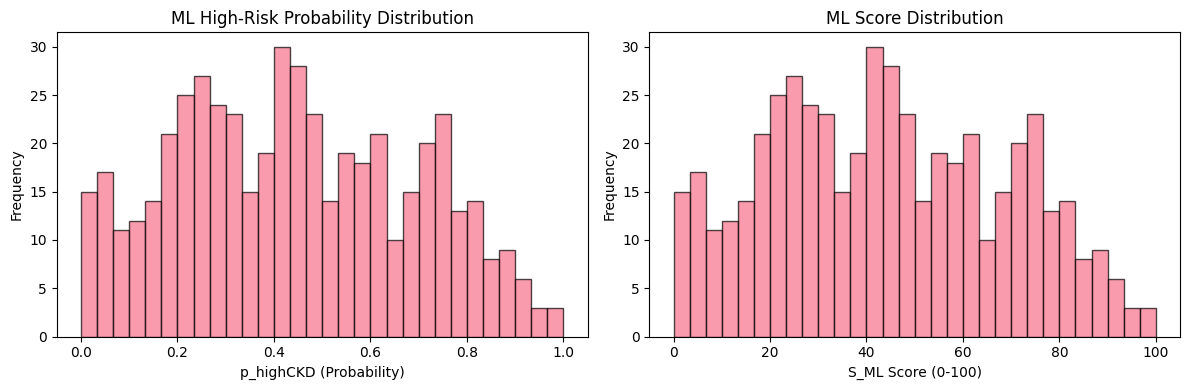

In [22]:
# Calculate ML-based scores for entire dataset

# Check if S_ML already exists in the synthetic dataset
if 'S_ML' in df_processed.columns and 'p_highCKD' in df_processed.columns:
    print("ML scores (S_ML and p_highCKD) already available in synthetic dataset!")
    print("Using pre-calculated values...")
    
    p_highCKD = df_processed['p_highCKD'].values
    S_ML = df_processed['S_ML'].values
    
    # Verify consistency between p_highCKD and S_ML
    calculated_S_ML = p_highCKD * 100
    s_ml_diff = np.abs(calculated_S_ML - S_ML)
    max_s_ml_diff = s_ml_diff.max()
    
    print(f"Maximum difference between calculated and existing S_ML: {max_s_ml_diff:.3f}")
    
    if max_s_ml_diff < 1.0:
        print("✓ Existing S_ML scores are consistent with p_highCKD * 100")
    else:
        print("⚠ Some differences found, using existing S_ML values from dataset")
        
else:
    # Calculate ML scores using trained model
    print("Calculating ML scores using trained model...")
    
    # Get predictions for entire dataset using best model
    if best_model_name == 'Logistic Regression':
        X_scaled_full = scaler.transform(X_imputed)
        p_highCKD = best_model.predict_proba(X_scaled_full)[:, 1]
    else:
        p_highCKD = best_model.predict_proba(X_imputed)[:, 1]
    
    # Calculate S_ML (0-100 subscore)
    S_ML = p_highCKD * 100
    
    # Add to dataframe
    df_processed['p_highCKD'] = p_highCKD
    df_processed['S_ML'] = S_ML

print("ML-based scoring completed!")
print(f"p_highCKD range: {p_highCKD.min():.4f} - {p_highCKD.max():.4f}")
print(f"S_ML range: {S_ML.min():.2f} - {S_ML.max():.2f}")

# Visualize ML scores
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(p_highCKD, bins=30, alpha=0.7, edgecolor='black')
plt.xlabel('p_highCKD (Probability)')
plt.ylabel('Frequency')
plt.title('ML High-Risk Probability Distribution')

plt.subplot(1, 2, 2)
plt.hist(S_ML, bins=30, alpha=0.7, edgecolor='black')
plt.xlabel('S_ML Score (0-100)')
plt.ylabel('Frequency')
plt.title('ML Score Distribution')

plt.tight_layout()
plt.show()

Composite scores and risk categories already available in synthetic dataset!
Validating existing calculations...
Maximum difference between calculated and existing Composite_Score: 21.030
⚠ Some differences found, recalculating Composite_Score...
Risk category consistency: 296/500 (59.2%)
⚠ Some differences found, recalculating Risk_Category...
Composite Scoring Results:
Composite Score range: 2.52 - 100.00

Risk Category Distribution:
Risk_Category
Low         337
Moderate    112
High         51
Name: count, dtype: int64

Risk Category Percentages:
Risk_Category
Low         67.4
Moderate    22.4
High        10.2
Name: proportion, dtype: float64


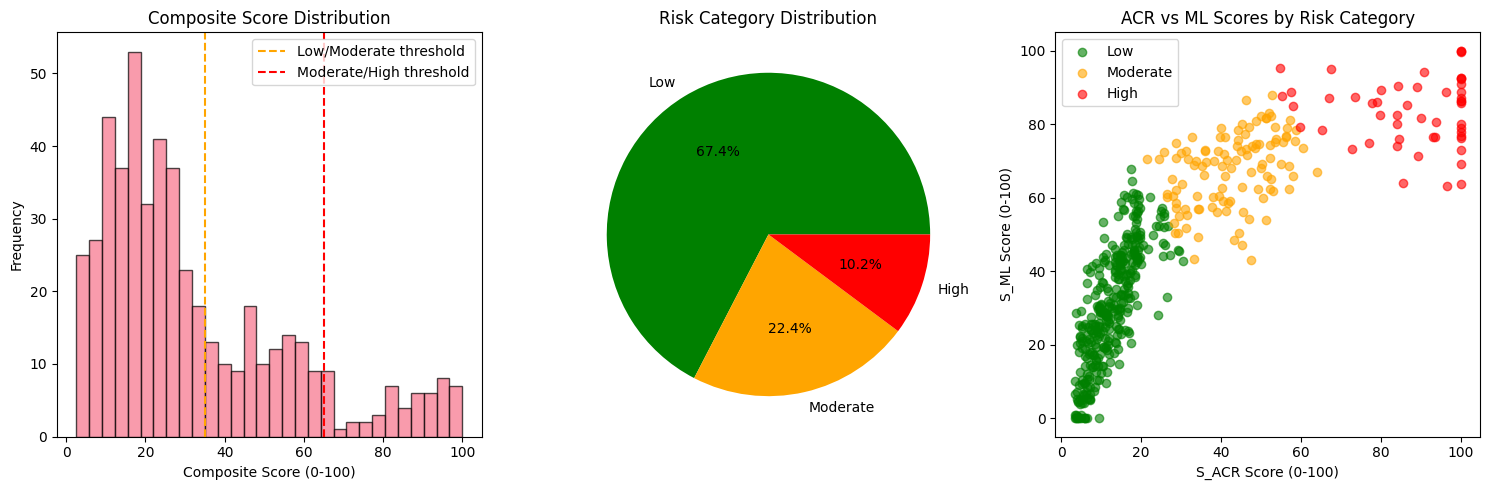

In [23]:
# Calculate Composite Score and Risk Categories

# Check if Composite_Score and Risk_Category already exist
if 'Composite_Score' in df_processed.columns and 'Risk_Category' in df_processed.columns:
    print("Composite scores and risk categories already available in synthetic dataset!")
    print("Validating existing calculations...")
    
    # Verify the composite score formula: 0.7 × S_ACR + 0.3 × S_ML
    calculated_composite = 0.7 * df_processed['S_ACR'] + 0.3 * df_processed['S_ML']
    existing_composite = df_processed['Composite_Score']
    
    composite_diff = np.abs(calculated_composite - existing_composite)
    max_composite_diff = composite_diff.max()
    
    print(f"Maximum difference between calculated and existing Composite_Score: {max_composite_diff:.3f}")
    
    if max_composite_diff < 1.0:
        print("✓ Existing Composite_Score is consistent with formula: 0.7 × S_ACR + 0.3 × S_ML")
    else:
        print("⚠ Some differences found, recalculating Composite_Score...")
        df_processed['Composite_Score'] = calculated_composite
    
    # Verify risk categories
    def categorize_risk(score):
        if score < 35:
            return 'Low'
        elif score < 65:
            return 'Moderate'
        else:
            return 'High'
    
    calculated_categories = df_processed['Composite_Score'].apply(categorize_risk)
    existing_categories = df_processed['Risk_Category']
    
    category_matches = (calculated_categories == existing_categories).sum()
    total_samples = len(df_processed)
    
    print(f"Risk category consistency: {category_matches}/{total_samples} ({category_matches/total_samples*100:.1f}%)")
    
    if category_matches == total_samples:
        print("✓ Existing Risk_Category is consistent with thresholds")
    else:
        print("⚠ Some differences found, recalculating Risk_Category...")
        df_processed['Risk_Category'] = calculated_categories

else:
    # Calculate composite scores and risk categories
    print("Calculating Composite Score and Risk Categories...")
    
    # Formula: Composite_Score = 0.7 × S_ACR + 0.3 × S_ML
    df_processed['Composite_Score'] = 0.7 * df_processed['S_ACR'] + 0.3 * df_processed['S_ML']
    
    # Risk Category based on Composite Score
    def categorize_risk(score):
        if score < 35:
            return 'Low'
        elif score < 65:
            return 'Moderate'
        else:
            return 'High'
    
    df_processed['Risk_Category'] = df_processed['Composite_Score'].apply(categorize_risk)

print("Composite Scoring Results:")
print(f"Composite Score range: {df_processed['Composite_Score'].min():.2f} - {df_processed['Composite_Score'].max():.2f}")
print("\nRisk Category Distribution:")
print(df_processed['Risk_Category'].value_counts())
print("\nRisk Category Percentages:")
print(df_processed['Risk_Category'].value_counts(normalize=True) * 100)

# Visualize composite scores and risk categories
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(df_processed['Composite_Score'], bins=30, alpha=0.7, edgecolor='black')
plt.axvline(35, color='orange', linestyle='--', label='Low/Moderate threshold')
plt.axvline(65, color='red', linestyle='--', label='Moderate/High threshold')
plt.xlabel('Composite Score (0-100)')
plt.ylabel('Frequency')
plt.title('Composite Score Distribution')
plt.legend()

plt.subplot(1, 3, 2)
risk_counts = df_processed['Risk_Category'].value_counts()
colors = ['green', 'orange', 'red']
# Ensure we have the right colors for each category
category_colors = []
for category in risk_counts.index:
    if category == 'Low':
        category_colors.append('green')
    elif category == 'Moderate':
        category_colors.append('orange')
    elif category == 'High':
        category_colors.append('red')

plt.pie(risk_counts.values, labels=risk_counts.index, autopct='%1.1f%%', colors=category_colors)
plt.title('Risk Category Distribution')

plt.subplot(1, 3, 3)
# Scatter plot of S_ACR vs S_ML colored by risk category
colors_map = {'Low': 'green', 'Moderate': 'orange', 'High': 'red'}
for category in df_processed['Risk_Category'].unique():
    mask = df_processed['Risk_Category'] == category
    plt.scatter(df_processed.loc[mask, 'S_ACR'], df_processed.loc[mask, 'S_ML'], 
               c=colors_map[category], label=category, alpha=0.6)
plt.xlabel('S_ACR Score (0-100)')
plt.ylabel('S_ML Score (0-100)')
plt.title('ACR vs ML Scores by Risk Category')
plt.legend()

plt.tight_layout()
plt.show()

In [29]:
# Scoring Formula Summary and Implementation

print("=" * 80)
print("CKD RISK SCORING FORMULA - IMPLEMENTATION SUMMARY")
print("=" * 80)

print("\n1. DERIVED SUB-SCORES:")
print("-" * 40)
print("• S_ACR (0-100): ACR-based subscore")
print("  - Normal (<30 mg/g): 0-20 points")
print("  - Microalbuminuria (30-300 mg/g): 20-60 points")
print("  - Macroalbuminuria (>300 mg/g): 60-100 points")
print()
print("• p_highCKD (0-1): ML probability of high-risk CKD")
print(f"  - Model used: {best_model_name}")
print(f"  - Model Performance:")
print(f"    · Accuracy:  {model_results[best_model_name]['accuracy']:.4f}")
print(f"    · Precision: {model_results[best_model_name]['precision']:.4f}")
print(f"    · Recall:    {model_results[best_model_name]['recall']:.4f}")
print(f"    · F1-Score:  {model_results[best_model_name]['f1_score']:.4f}")
print(f"    · AUC:       {model_results[best_model_name]['auc']:.4f}")
print()
print("• S_ML (0-100): ML subscore = p_highCKD × 100")

print("\n2. FINAL TARGETS:")
print("-" * 40)
print("• Composite_Score (0-100): 0.7 × S_ACR + 0.3 × S_ML")
print("• Risk_Category:")
print("  - Low: Score < 35")
print("  - Moderate: 35 ≤ Score < 65")
print("  - High: Score ≥ 65")

print("\n3. FEATURE INPUTS:")
print("-" * 40)
for i, feature in enumerate(feature_names, 1):
    print(f"{i:2d}. {feature}")

print("\n4. SCORING STATISTICS:")
print("-" * 40)
print(f"S_ACR - Mean: {df_processed['S_ACR'].mean():.2f}, Std: {df_processed['S_ACR'].std():.2f}")
print(f"S_ML  - Mean: {df_processed['S_ML'].mean():.2f}, Std: {df_processed['S_ML'].std():.2f}")
print(f"Composite - Mean: {df_processed['Composite_Score'].mean():.2f}, Std: {df_processed['Composite_Score'].std():.2f}")

print("\n5. RISK DISTRIBUTION:")
print("-" * 40)
risk_dist = df_processed['Risk_Category'].value_counts()
for category in ['Low', 'Moderate', 'High']:
    if category in risk_dist:
        count = risk_dist[category]
        percent = (count / len(df_processed)) * 100
        print(f"{category:8s}: {count:4d} patients ({percent:5.1f}%)")

print("\n6. MODEL COMPARISON:")
print("-" * 40)
print(f"{'Model':<20} {'Accuracy':<9} {'Precision':<9} {'Recall':<9} {'F1-Score':<9} {'AUC':<9}")
print("-" * 75)
for name in model_results.keys():
    metrics = model_results[name]
    marker = "★" if name == best_model_name else " "
    print(f"{marker} {name:<19} {metrics['accuracy']:<9.4f} {metrics['precision']:<9.4f} {metrics['recall']:<9.4f} {metrics['f1_score']:<9.4f} {metrics['auc']:<9.4f}")

print("\n" + "=" * 80)

CKD RISK SCORING FORMULA - IMPLEMENTATION SUMMARY

1. DERIVED SUB-SCORES:
----------------------------------------
• S_ACR (0-100): ACR-based subscore
  - Normal (<30 mg/g): 0-20 points
  - Microalbuminuria (30-300 mg/g): 20-60 points
  - Macroalbuminuria (>300 mg/g): 60-100 points

• p_highCKD (0-1): ML probability of high-risk CKD
  - Model used: Random Forest
  - Model Performance:
    · Accuracy:  0.9000
    · Precision: 0.9394
    · Recall:    0.7949
    · F1-Score:  0.8611
    · AUC:       0.9588

• S_ML (0-100): ML subscore = p_highCKD × 100

2. FINAL TARGETS:
----------------------------------------
• Composite_Score (0-100): 0.7 × S_ACR + 0.3 × S_ML
• Risk_Category:
  - Low: Score < 35
  - Moderate: 35 ≤ Score < 65
  - High: Score ≥ 65

3. FEATURE INPUTS:
----------------------------------------
 1. Age
 2. Sex
 3. Hypertension
 4. Diabetes
 5. Urine_Creatinine_mg_dL
 6. Urine_Albumin_mg_L
 7. ACR_mg_per_g
 8. pH
 9. Specific_Gravity
10. Serum_Creatinine_mg_dL

4. SCORING STAT

In [25]:
# Save results and create final output

# Create final results dataframe with required columns
# Using correct column names from synthetic dataset
results_df = pd.DataFrame({
    'Patient_ID': range(1, len(df_processed) + 1),
    'Age': df_processed['Age'],  # Use 'Age' from synthetic dataset
    'Sex': df_processed['Sex'],  # Use 'Sex' from synthetic dataset
    'Hypertension': df_processed['Hypertension'],  # Use 'Hypertension' from synthetic dataset
    'Diabetes': df_processed['Diabetes'],  # Use 'Diabetes' from synthetic dataset
    'Urine_Creatinine_mg_dL': df_processed['Urine_Creatinine_mg_dL'],  # Correct column name
    'Urine_Albumin_mg_L': df_processed['Urine_Albumin_mg_L'],  # Correct column name
    'ACR_mg_per_g': df_processed['ACR_mg_per_g'],
    'pH': df_processed['pH'],
    'Specific_Gravity': df_processed['Specific_Gravity'],  # Correct column name
    'Serum_Creatinine_mg_dL': df_processed['Serum_Creatinine_mg_dL'],  # Correct column name
    'S_ACR': df_processed['S_ACR'],
    'p_highCKD': df_processed['p_highCKD'],
    'S_ML': df_processed['S_ML'],
    'Composite_Score': df_processed['Composite_Score'],
    'Risk_Category': df_processed['Risk_Category']
})

# Save to CSV
output_filename = 'kidney_risk_analysis_results_synthetic_20251120.csv'
results_df.to_csv(output_filename, index=False)
print(f"Results saved to: {output_filename}")

# Display sample results
print("\nSample Results (first 10 patients):")
print(results_df[['Patient_ID', 'Age', 'Sex', 'ACR_mg_per_g', 'S_ACR', 'S_ML', 
                 'Composite_Score', 'Risk_Category']].head(10))

print(f"\nTotal patients analyzed: {len(results_df)}")
print(f"Dataset shape: {results_df.shape}")

# Display summary statistics
print(f"\nSummary Statistics:")
print(f"Age range: {results_df['Age'].min()}-{results_df['Age'].max()} years")
print(f"ACR range: {results_df['ACR_mg_per_g'].min():.1f}-{results_df['ACR_mg_per_g'].max():.1f} mg/g")
print(f"Composite Score range: {results_df['Composite_Score'].min():.1f}-{results_df['Composite_Score'].max():.1f}")
print(f"\nRisk Category Distribution:")
for category, count in results_df['Risk_Category'].value_counts().items():
    percentage = (count / len(results_df)) * 100
    print(f"  {category}: {count} patients ({percentage:.1f}%)")

Results saved to: kidney_risk_analysis_results_synthetic_20251120.csv

Sample Results (first 10 patients):
   Patient_ID  Age Sex  ACR_mg_per_g      S_ACR  S_ML  Composite_Score  \
0           1   58   F          17.4  11.600000  35.3        18.710000   
1           2   70   F           5.4   3.600000   0.0         2.520000   
2           3   45   M          27.9  18.600000  41.8        25.560000   
3           4   47   M         247.1  52.162963  83.0        61.414074   
4           5   63   F           7.5   5.000000   0.0         3.500000   
5           6   65   M         274.6  56.237037  76.8        62.405926   
6           7   49   F          10.9   7.266667   4.9         6.556667   
7           8   20   M          26.2  17.466667  49.2        26.986667   
8           9   57   M          26.3  17.533333  20.4        18.393333   
9          10   36   M          54.6  23.644444  52.2        32.211111   

  Risk_Category  
0           Low  
1           Low  
2           Low  
3     

In [26]:
# Final Formula Implementation Functions

def calculate_ckd_risk_score(age, sex, hypertension, diabetes, urine_creatinine, 
                            urine_albumin, acr, ph, specific_gravity, serum_creatinine,
                            ml_model=None, scaler=None):
    """
    Complete CKD Risk Scoring Function
    
    Inputs:
    - age: Patient age
    - sex: 'M' or 'F' 
    - hypertension: 0 or 1
    - diabetes: 0 or 1
    - urine_creatinine: mg/dL
    - urine_albumin: mg/L
    - acr: mg/g (Albumin-to-Creatinine Ratio)
    - ph: Urine pH
    - specific_gravity: Urine specific gravity
    - serum_creatinine: mg/dL
    - ml_model: Trained ML model (optional, uses default if None)
    - scaler: Feature scaler (optional)
    
    Returns:
    - Dictionary with S_ACR, p_highCKD, S_ML, Composite_Score, Risk_Category
    """
    
    # 1. Calculate S_ACR (0-100)
    if acr < 30:
        s_acr = (acr / 30) * 20
    elif acr < 300:
        s_acr = 20 + ((acr - 30) / 270) * 40
    else:
        s_acr = 60 + min(((acr - 300) / 700) * 40, 40)
    
    # 2. Calculate p_highCKD using ML model
    if ml_model is not None:
        # Prepare features
        features = np.array([[
            age, 
            1 if sex == 'M' else 0,
            hypertension,
            diabetes,
            urine_creatinine,
            urine_albumin,
            acr,
            ph,
            specific_gravity,
            serum_creatinine
        ]])
        
        # Scale if needed
        if scaler is not None:
            features = scaler.transform(features)
        
        # Get probability
        p_high_ckd = ml_model.predict_proba(features)[0, 1]
    else:
        # Default risk calculation without ML model
        risk_factors = 0
        if acr > 300: risk_factors += 3
        elif acr > 30: risk_factors += 1
        if age > 65: risk_factors += 1
        if diabetes: risk_factors += 1
        if hypertension: risk_factors += 1
        if serum_creatinine > 1.5: risk_factors += 2
        
        p_high_ckd = min(risk_factors / 8.0, 1.0)  # Normalize to 0-1
    
    # 3. Calculate S_ML (0-100)
    s_ml = p_high_ckd * 100
    
    # 4. Calculate Composite Score
    composite_score = 0.7 * s_acr + 0.3 * s_ml
    
    # 5. Determine Risk Category
    if composite_score < 35:
        risk_category = 'Low'
    elif composite_score < 65:
        risk_category = 'Moderate'
    else:
        risk_category = 'High'
    
    return {
        'S_ACR': s_acr,
        'p_highCKD': p_high_ckd,
        'S_ML': s_ml,
        'Composite_Score': composite_score,
        'Risk_Category': risk_category
    }

# Example usage
print("CKD Risk Scoring Function Implementation Complete!")
print("\nExample calculation:")

# Test with sample patient
sample_result = calculate_ckd_risk_score(
    age=65, sex='M', hypertension=1, diabetes=1,
    urine_creatinine=150, urine_albumin=200, acr=133,
    ph=6.0, specific_gravity=1.020, serum_creatinine=1.3,
    ml_model=best_model, scaler=scaler if best_model_name == 'Logistic Regression' else None
)

print("Sample Patient (65yr old male, HTN+DM):")
for key, value in sample_result.items():
    if key in ['S_ACR', 'S_ML', 'Composite_Score']:
        print(f"  {key}: {value:.2f}")
    elif key == 'p_highCKD':
        print(f"  {key}: {value:.4f}")
    else:
        print(f"  {key}: {value}")

print("\nFormula ready for deployment!")

CKD Risk Scoring Function Implementation Complete!

Example calculation:
Sample Patient (65yr old male, HTN+DM):
  S_ACR: 35.26
  p_highCKD: 0.5100
  S_ML: 51.00
  Composite_Score: 39.98
  Risk_Category: Moderate

Formula ready for deployment!
